
# Project: Patients' appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

Hello! <br>
in this notebook, I am going to explore a dataset which provides records for patients in brazil. <br>
the dataset contains, regular info about patients, like their ID, when did they schedule their appointments, any conditions they have like: diabetes, hipertension, etc... <br>
but most importantly is whether or not they will show up to that appointment! which will be our main focus here.

So let's Start by setting up the environment.

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests

#make plots appear in the notebook
%matplotlib inline 
#setting style for plots
sns.set_context('notebook') 
sns.set_style('whitegrid')

<a id='wrangling'></a>
## Data Wrangling

Now we need to get our dataset, luckily we are provided a link to a really good data set. <br>
so let's download it and load into pandas.

### General Properties

In [2]:
# importing the data using the link (for reproducibility)
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv'
r = requests.get(url)
with open('data.csv', 'wb') as f:
    f.write(r.content)
data_path = 'data.csv'

In [3]:
#load data into pandas
df = pd.read_csv(data_path)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
#get a general idea of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Well, These look good! no null data which is amazing, but it requires a few changes at first glance, <br>
firt of all:<br>
     These column names aren't following the convention and might be hard to work with, let's fix that!

In [5]:
#create a list of new col names following the lower case convention, it makes it easier for me :)
new_cols = []
for col in df.columns[:-2]:
    s=re.findall('.[^A-Z]*', col)
    s= '_'.join(s).lower()
    new_cols.append(s)

#hardcoding a few of them
new_cols[1] = 'appointment_id'
new_cols.append('sms_received')
new_cols.append('show_up')

In [6]:
#renaming the dataframe columns
df.columns = new_cols
df.columns

Index(['patient_id', 'appointment_id', 'gender', 'scheduled_day',
       'appointment_day', 'age', 'neighbourhood', 'scholarship',
       'hipertension', 'diabetes', 'alcoholism', 'handcap', 'sms_received',
       'show_up'],
      dtype='object')

Now the No-Show column is a bit confusing, so to make this easier, we are going to switch the ('No' value in 'No-show' column) (which means the patient did show up) to a less confusing form which is ( 1 in a 'show_up' column), and 0 for 'Yes'.

In [7]:
#fix no-show column to be less confusing
df['show_up'] = df['show_up'].apply(lambda x: 1 if x=='No' else 0)

In [8]:
#checking dataframe
df.sample(3)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show_up
65323,2.671358e+10,5735638,F,2016-05-25T07:22:23Z,2016-05-25T00:00:00Z,13,JARDIM DA PENHA,0,0,0,0,0,0,1
86482,9.796670e+14,5703967,F,2016-05-16T14:48:08Z,2016-06-01T00:00:00Z,5,DA PENHA,0,0,0,0,0,1,1
48370,2.372868e+13,5711789,F,2016-05-18T08:03:36Z,2016-05-18T00:00:00Z,4,PIEDADE,1,0,0,0,0,0,1


Now let's check if there are any false data.

In [9]:
df['gender'].value_counts()

F    71840
M    38687
Name: gender, dtype: int64

In [10]:
df.describe()

,patient_id,appointment_id,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show_up
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.798067
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


Now there seem to be something weird values in the age column, let's check it out.

In [11]:
df['age'].value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: age, Length: 104, dtype: int64

There seems to be 1 wrong value (-1), and some very unlikely values like: 115, 100, 102, etc...
while its rare to see people this old, they are a minority and will barely affect the analysis.

Now let's see the handcap column, the data should only be 0 or 1 but there are others..

In [12]:
df['handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: handcap, dtype: int64

These values seem unusual, and are not likely to be typing mistakes. <br><br>

In [13]:
df['sms_received'].value_counts()

0    75045
1    35482
Name: sms_received, dtype: int64

And since the sms_received column refers to the number of SMS, which could be more than one, it only has 0 and 1 values; it could be that the handcap and sms_received columns got switched up! <br>
The distribution of values for both columns further confirms my theory, so I will work with that, hopefully I am not wrong.

Now let's check to see whether the boolean columns (scholarship to handcap) are overlapping or not, because if there were no overlaps, they could all be represented in one column!

In [14]:
#summing the 1's in the columns horizontally
overlap = df.iloc[:, [7, 8, 9, 10, 12]].sum(axis=1)
overlap.value_counts()

0    51877
1    41498
2    13763
3     3139
4      244
5        6
dtype: int64

Well, they seem to have overlapping values.

finally, let's check if there are any correlations

Text(84.453125, 0.5, 'columns')

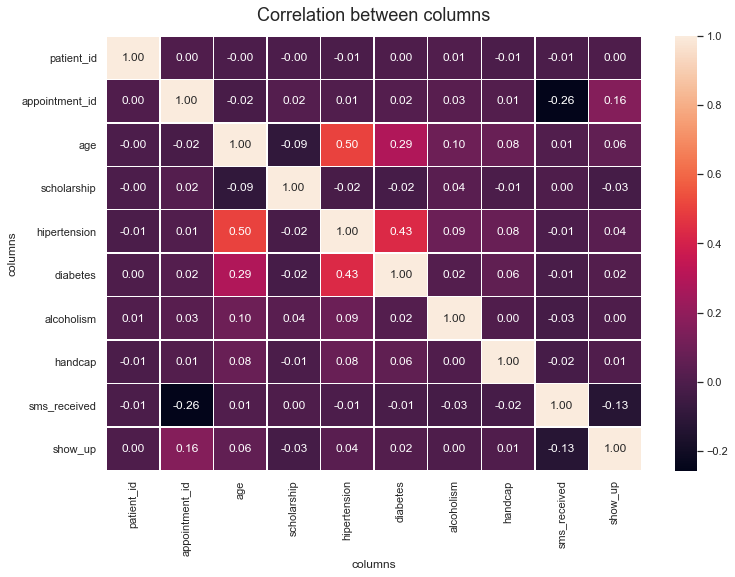

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt='.2f', ax=ax)
ax.set_title('Correlation between columns', size=18, y=1.02)
ax.set_xlabel('columns')
ax.set_ylabel('columns')

Well, I guess we have explored enough, let's move on to the next phase, cleaning the data! <br>
these are some of the issues I found:

## Data Cleaning:
#### Quality:
 - patient_id not in the right data type. <br>
 - appointment_id not in the right data type. <br>
 - scheduled_day not in datetime type. <br>
 - appointment_day not in datetime type. <br>
 - extreme data in age. <br>
 - switched handcap and sms columns. <br>
 - drop duplicated appointments. (discovered later)

#### Tidiness:
 - Extract day of Week from both Sched and Appoint days (to check whether holidays have an effect on showing up). <br>
 - Extract duration between sched and appoint. <br>
 - fix column naming (done).

Now let's start cleaning those..

In [16]:
#convert patient id to str
df['patient_id'] = df['patient_id'].apply(int).apply(str)

In [17]:
#convert appointment id to str
df['appointment_id'] = df['appointment_id'].apply(str)

In [18]:
#convert dates to the right format
df['appointment_day'] = pd.to_datetime(df['appointment_day'])
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])

In [19]:
#general look at types to check if I've missed something
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   patient_id       110527 non-null  object             
 1   appointment_id   110527 non-null  object             
 2   gender           110527 non-null  object             
 3   scheduled_day    110527 non-null  datetime64[ns, UTC]
 4   appointment_day  110527 non-null  datetime64[ns, UTC]
 5   age              110527 non-null  int64              
 6   neighbourhood    110527 non-null  object             
 7   scholarship      110527 non-null  int64              
 8   hipertension     110527 non-null  int64              
 9   diabetes         110527 non-null  int64              
 10  alcoholism       110527 non-null  int64              
 11  handcap          110527 non-null  int64              
 12  sms_received     110527 non-null  int64              
 13 

In [20]:
#remove that wrong record 
df.drop(index=df.query('age < 0').index, inplace=True)

Text(0, 0.5, 'counts')

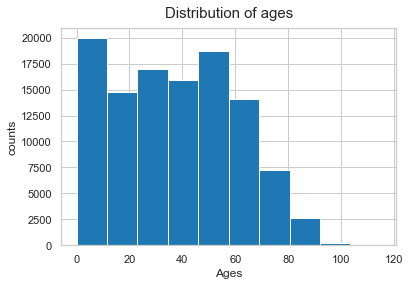

In [21]:
fig, ax = plt.subplots()
ax = df['age'].hist()
ax.set_title('Distribution of ages', size=15, y=1.02)
ax.set_xlabel('Ages')
ax.set_ylabel('counts')

Now let's check for typos in ages over 100, like typing 115 instead of 15, by checking all patient id's

In [22]:
#filter old patients by id 
check_id = df.query('age >= 100')['patient_id']
df[df['patient_id'].isin(check_id)]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show_up
58014,976294799775439,5651757,F,2016-05-03 09:14:53+00:00,2016-05-03 00:00:00+00:00,102,CONQUISTA,0,0,0,0,0,0,1
63912,31963211613981,5700278,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,0
63915,31963211613981,5700279,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,0
68127,31963211613981,5562812,F,2016-04-08 14:29:17+00:00,2016-05-16 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,0
76284,31963211613981,5744037,F,2016-05-30 09:44:51+00:00,2016-05-30 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,1
79270,9739429797896,5747809,M,2016-05-30 16:21:56+00:00,2016-05-31 00:00:00+00:00,100,TABUAZEIRO,0,0,0,0,1,0,1
79272,9739429797896,5747808,M,2016-05-30 16:21:56+00:00,2016-05-31 00:00:00+00:00,100,TABUAZEIRO,0,0,0,0,1,0,1
90372,234283596548,5751563,F,2016-05-31 10:19:49+00:00,2016-06-02 00:00:00+00:00,102,MARIA ORTIZ,0,0,0,0,0,0,1
92084,55783129426615,5670914,F,2016-05-06 14:55:36+00:00,2016-06-03 00:00:00+00:00,100,ANTÔNIO HONÓRIO,0,0,0,0,0,1,1
97666,748234579244724,5717451,F,2016-05-19 07:57:56+00:00,2016-06-03 00:00:00+00:00,115,SÃO JOSÉ,0,1,0,0,0,1,1


Well no typos there, but I have noticed some duplicate records with different appointment id's, let's check that out!

In [23]:
#check how many patient scheduled an appointment more than once at the exact same time
df.duplicated(subset=['patient_id', 'scheduled_day']).sum()

1334

looks like there are a lot of those! 

In [24]:
#drop duplicated records
df.drop_duplicates(subset=['patient_id', 'scheduled_day'], inplace=True)

Now let's switch the handcap and the sms_received data

In [25]:
df_dup = df.copy()

In [26]:
df['sms_received'], df['handcap'] = df_dup['handcap'], df_dup['sms_received']

In [27]:
df.describe()

,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show_up
count,109192.000000,109192.000000,109192.000000,109192.000000,109192.000000,109192.000000,109192.000000,109192.000000
mean,37.097351,0.098231,0.197377,0.071864,0.030497,0.322872,0.022199,0.799793
std,23.140676,0.297628,0.398021,0.258264,0.171950,0.467576,0.161109,0.400157
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [28]:
#extracting the day of the week from data
df['scheduled_dow'] = df['scheduled_day'].dt.day_name()
df['appointment_dow'] = df['appointment_day'].dt.day_name()

In [29]:
#calculate how far the appointment day is from the scheduling day
df['waiting_days'] = (df['appointment_day'] - df['scheduled_day'].dt.normalize()).dt.days

In [30]:
#reordering the columns
cols = df_dup.columns.to_list()
cols[5:5] = df.columns[-3:]
df = df[cols]

In [31]:
df.sample(5)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,scheduled_dow,appointment_dow,waiting_days,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show_up
70658,744915698935251,5693659,M,2016-05-13 07:32:13+00:00,2016-05-25 00:00:00+00:00,Friday,Wednesday,12,68,BARRO VERMELHO,0,1,0,0,1,0,1
30523,5162433585148,5638037,F,2016-04-29 07:39:23+00:00,2016-05-12 00:00:00+00:00,Friday,Thursday,13,56,CENTRO,0,0,0,0,1,0,1
44488,85374572175451,5701699,F,2016-05-16 10:53:00+00:00,2016-05-24 00:00:00+00:00,Monday,Tuesday,8,8,REPÚBLICA,0,0,0,0,1,0,0
77681,64533312189716,5664333,F,2016-05-05 11:54:48+00:00,2016-05-05 00:00:00+00:00,Thursday,Thursday,0,24,ITARARÉ,0,0,0,0,0,0,1
109773,312269142492657,5773505,M,2016-06-06 07:16:50+00:00,2016-06-08 00:00:00+00:00,Monday,Wednesday,2,69,JARDIM CAMBURI,0,0,0,0,0,0,1


<a id='eda'></a>
## Exploratory Data Analysis

Now since the data is ready to work with, let's dive right into it! <br>
starting with a fairyl obviouse question...

### What is the rate of showing up ?

<AxesSubplot:title={'center':'Percentage of patients Showing Up'}, xlabel='Show up', ylabel='Percentage'>

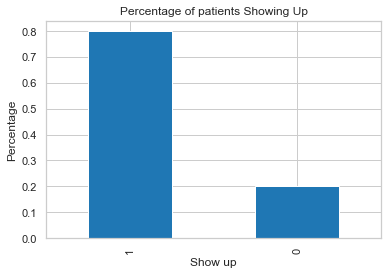

In [32]:
df['show_up'].value_counts(normalize=True).plot(kind='bar', title='Percentage of patients Showing Up', 
                                                xlabel='Show up', ylabel='Percentage')

So based on the data we have, 80% of people show up, but 20% don't! <br>
and we can see that over time here:

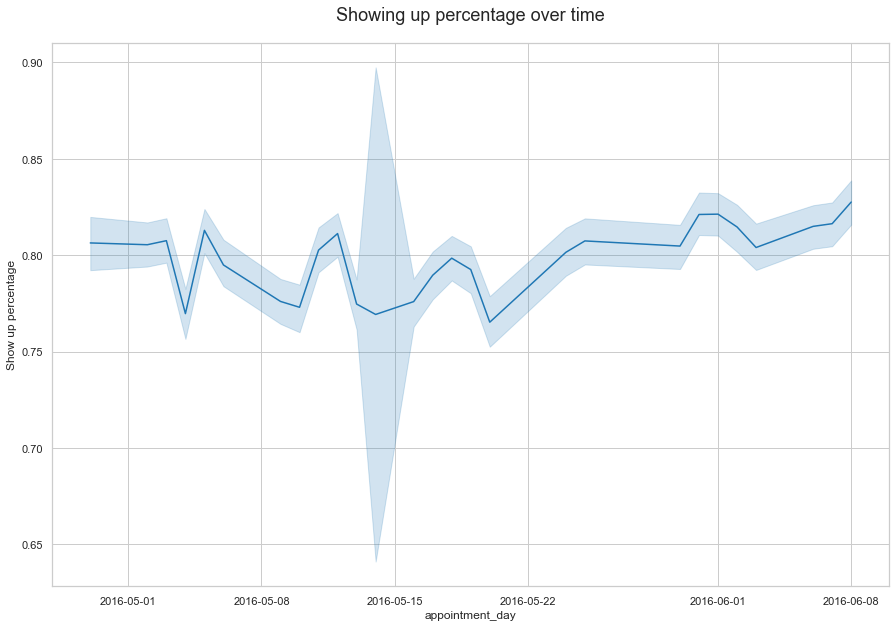

In [33]:
#plot the percentage of showing up over time
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=df, x='appointment_day', y='show_up', ax=ax)
ax.set_title('Showing up percentage over time', y=1.03, size=18)
ax.set_ylabel('Show up percentage')
plt.show()

It seems fairly the same, with a few spikes along the way, and from here some questions do come to mind, like: <br><br>

- does this have anything to do with age or gender ? <br>
- is the day of the week relevant ? <br>
- does the waiting period affect showing up ? <br>
- are multiple appointments a probelm ? <br>
- are some neighbourhoods better than others ? <br>
- does sending out sms help? <br>
- are people with diseases more likely to show up ? <br>

### Does age or gender affect showing up?

Text(0.5, 1.02, 'Distribution of ages divided by showing up')

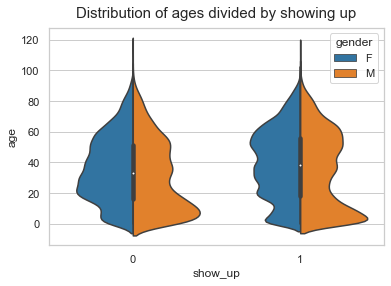

In [34]:
g = sns.violinplot(data=df, y='age', hue='gender', split=True, x='show_up')
g.set_title('Distribution of ages divided by showing up', size=15, y=1.02)

Well, turns out it there's no clear correlation, both distributions look similar.

### Does the day of the week affect showing up ?

In [35]:
df['appointment_dow'].value_counts()

Wednesday    25572
Tuesday      25313
Monday       22449
Friday       18739
Thursday     17080
Saturday        39
Name: appointment_dow, dtype: int64

Text(0.47, 1.04, 'Counts of people that Show up per day of week')

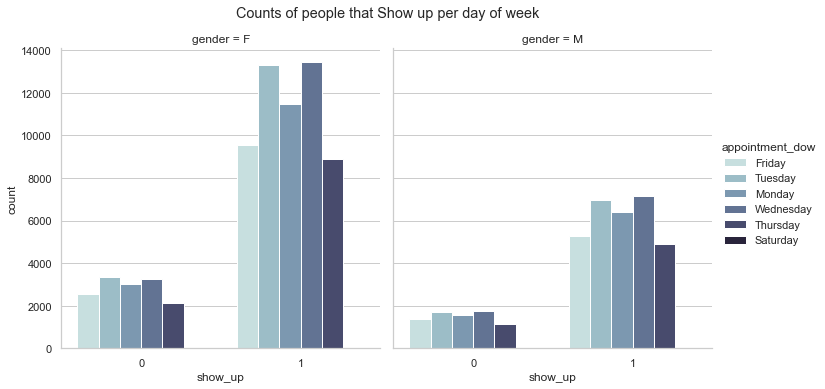

In [36]:
g=sns.catplot(data = df, kind='count', x='show_up', hue='appointment_dow', col='gender', palette='ch:start=.2,rot=-.3')
g.fig.suptitle('Counts of people that Show up per day of week', y=1.04, x=0.47)

In [37]:
df.query('appointment_dow == "Saturday"')

,patient_id,appointment_id,gender,scheduled_day,appointment_day,scheduled_dow,appointment_dow,waiting_days,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show_up
72295,9656743739937,5647188,F,2016-05-02 13:08:18+00:00,2016-05-14 00:00:00+00:00,Monday,Saturday,12,60,SANTO ANTÔNIO,0,0,0,0,1,0,1
72296,261246839673951,5692771,M,2016-05-12 16:13:24+00:00,2016-05-14 00:00:00+00:00,Thursday,Saturday,2,56,CARATOÍRA,0,0,0,0,0,0,0
72297,62197183951413,5668696,F,2016-05-06 09:35:30+00:00,2016-05-14 00:00:00+00:00,Friday,Saturday,8,27,CARATOÍRA,1,0,0,0,1,0,1
72298,1715927721832,5646878,M,2016-05-02 12:02:42+00:00,2016-05-14 00:00:00+00:00,Monday,Saturday,12,75,CARATOÍRA,0,1,1,0,0,0,1
72299,61824462897921,5673055,F,2016-05-09 08:50:55+00:00,2016-05-14 00:00:00+00:00,Monday,Saturday,5,67,CARATOÍRA,0,0,0,0,1,0,1
72300,4494621843431,5674445,F,2016-05-09 11:04:56+00:00,2016-05-14 00:00:00+00:00,Monday,Saturday,5,72,CARATOÍRA,0,1,1,0,1,0,1
72301,63556226728883,5674448,M,2016-05-09 11:05:15+00:00,2016-05-14 00:00:00+00:00,Monday,Saturday,5,52,CARATOÍRA,0,0,1,0,1,0,1
72302,59671168441693,5646085,M,2016-05-02 10:49:40+00:00,2016-05-14 00:00:00+00:00,Monday,Saturday,12,31,ARIOVALDO FAVALESSA,0,0,0,0,1,1,1
72303,67167685484615,5646088,F,2016-05-02 10:49:54+00:00,2016-05-14 00:00:00+00:00,Monday,Saturday,12,52,ARIOVALDO FAVALESSA,0,0,0,0,0,0,1
72304,7367167111123,5678814,F,2016-05-10 09:06:06+00:00,2016-05-14 00:00:00+00:00,Tuesday,Saturday,4,58,CARATOÍRA,0,0,0,0,1,0,1


As the plot shows, wednesdays and tuesdays are the busiest of days! <br>
while sundays and saturdays are obviously holidays, there seem to be a few cases on satudays!
but they are relatively negligible! <br><br>
And as the data shows, it seems to be only one saturday, the 14th of May!

### Is there a relation between the number of waiting days and patients showing up?

Text(0.5, 1.05, 'Distributions of Waiting days')

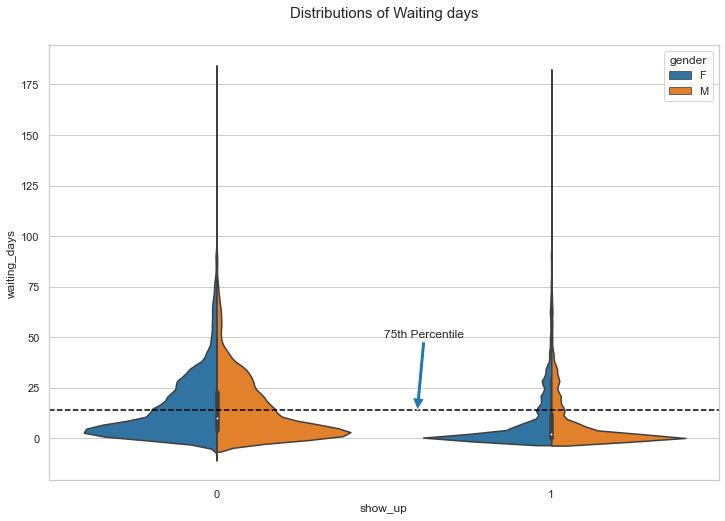

In [38]:
pct_75 = df['waiting_days'].quantile(0.75)
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.violinplot(data=df, y='waiting_days', x='show_up', hue='gender', split=True)
ax.axhline(y=pct_75, linestyle='--', c='k')
ax.annotate('75th Percentile', xy=(0.6, pct_75), xytext=(0.5, 50), arrowprops={})
ax.set_title('Distributions of Waiting days', size=15, y=1.05)

In [39]:
pct_75

14.0

well it looks like patients tend not to show up with more waiting days! <br>
75 percent of the patients that show up, wait a max of 14 days, then the count of patients that more than that AND actually show up, is far less than that of those that do not show up.

### How likely is the same patient to show up more than once?

In [40]:
#get the number of unique patients
df['patient_id'].nunique()

62298

In [41]:
dup = df[df.duplicated(subset='patient_id')]
dup.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,scheduled_dow,appointment_dow,waiting_days,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show_up
27,12154843752835,5628345,F,2016-04-27 10:51:45+00:00,2016-04-29 00:00:00+00:00,Wednesday,Friday,2,4,CONQUISTA,0,0,0,0,0,0,1
290,7222383233748,5566070,M,2016-04-11 09:50:18+00:00,2016-04-29 00:00:00+00:00,Monday,Friday,18,7,CARATOÍRA,0,0,0,0,1,0,1
316,17565785761493,5582867,F,2016-04-14 10:01:09+00:00,2016-04-29 00:00:00+00:00,Thursday,Friday,15,1,JOANA D´ARC,0,0,0,0,0,0,1
344,821863135212,5638396,F,2016-04-29 07:59:32+00:00,2016-04-29 00:00:00+00:00,Friday,Friday,0,23,SÃO CRISTÓVÃO,1,0,0,1,0,0,1
415,7273891836976,5601968,F,2016-04-19 14:02:07+00:00,2016-04-29 00:00:00+00:00,Tuesday,Friday,10,29,ITARARÉ,1,0,0,0,0,0,0


Text(0.5, 1.0, 'Percentage of patients that show up more than once')

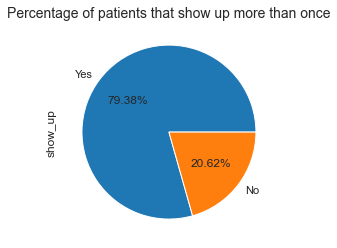

In [42]:
fig, ax = plt.subplots()
ax = dup['show_up'].value_counts().plot(kind='pie', autopct='%0.2f%%', labels=['Yes', 'No']);
ax.set_title('Percentage of patients that show up more than once', size=14)

well, based on patient IDs, only 62298 are unique patients, the rest of the records are the same patients making other appointments, in 80% of those appointments the patients DO show up again, which is roughly the same percentage of showing up.

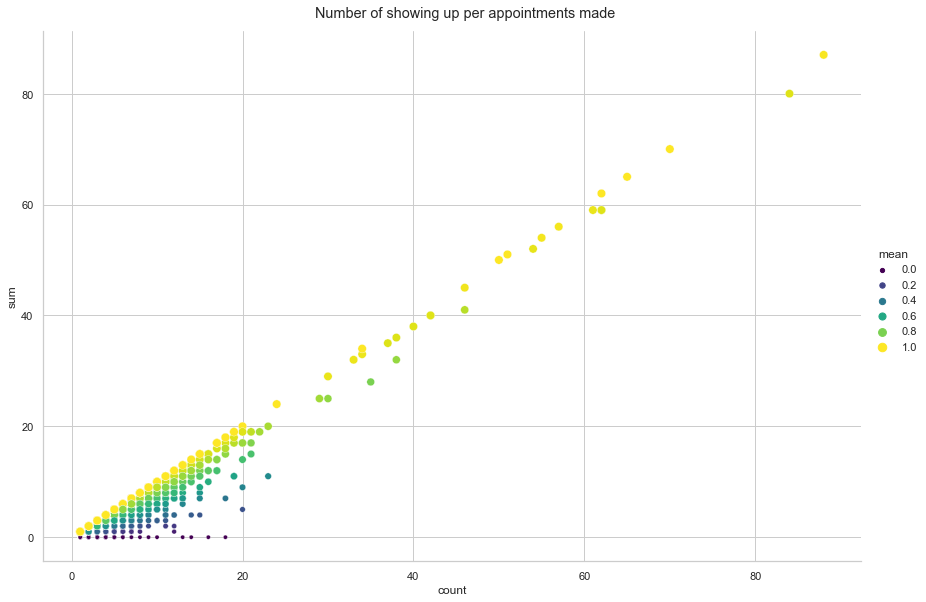

In [43]:
patients = df.groupby('patient_id')['show_up'].agg(['sum', 'count', 'mean']).sort_values(by='count', ascending=False)
g = sns.relplot(kind='scatter', data=patients, x='count', y='sum', 
                size='mean', hue='mean', palette='viridis', height=8, aspect=1.5,)
g.fig.suptitle('Number of showing up per appointments made', y=1.02);

But as you can see in this graph, as the same patient makes more appointments, the chances are that he/she will show up!

### Which neighbourhoods have the highest chance of patients showing up and not showing up ?

In [44]:
# Create a function for plotting to avoid repetitive code
def my_plot(typ, norm, df):
    neib = df.groupby('neighbourhood')['show_up'].value_counts(normalize=norm).rename(typ).reset_index()
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 8))

    neib_show = neib.sort_values(by=['show_up', typ], ascending=False).iloc[:10]
    sns.barplot(data=neib_show,
                x='neighbourhood', y=typ, ax=ax[0])
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[0].set_title('Show up = 1')

    neib_noshow = neib.sort_values(by=['show_up', typ], ascending=[True, False]).iloc[:10]
    sns.barplot(data=neib_noshow,
                x='neighbourhood', y=typ, ax=ax[1])
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_title('Show up = 0')
    fig.suptitle('{}s of patients by neighbourhood'.format(typ.title()))
    plt.show()
    
    return neib_show, neib_noshow

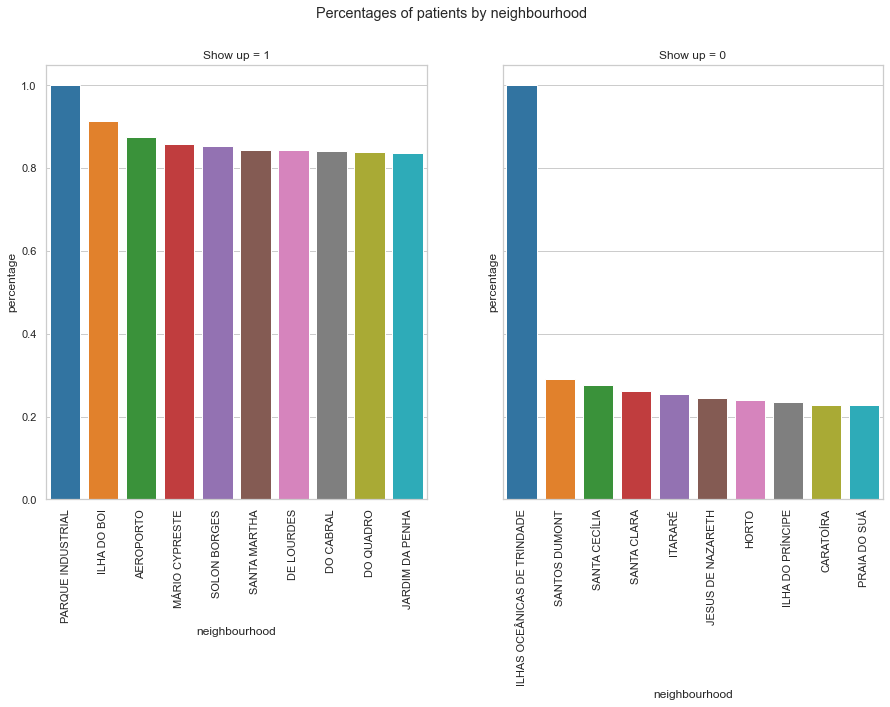

In [45]:
neib_show, neib_noshow = my_plot('percentage', True, df)

So this is show the neighbourhood with most percentages of showing up and not showing up! <br>
We have here some suspiciously looking reighbourhoods in both areas, probably these have few records and all of which have the same show up case, let's check it out!

In [46]:
df[df['neighbourhood'] == neib_show.iloc[0, 0]]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,scheduled_dow,appointment_dow,waiting_days,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show_up
75199,8255992453538,5663947,F,2016-05-05 10:48:59+00:00,2016-05-05 00:00:00+00:00,Thursday,Thursday,0,17,PARQUE INDUSTRIAL,0,0,0,0,0,0,1


In [47]:
df[df['neighbourhood'] == neib_noshow.iloc[0, 0]]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,scheduled_dow,appointment_dow,waiting_days,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,show_up
48754,534986855114,5583947,F,2016-04-14 12:25:43+00:00,2016-05-13 00:00:00+00:00,Thursday,Friday,29,51,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,0
48765,7256429752481,5583948,F,2016-04-14 12:26:13+00:00,2016-05-13 00:00:00+00:00,Thursday,Friday,29,58,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,0


yup, sure does look like it, so let's tweek the code a bit, to get the neighbourhoods with the highest counts, and the cross reference those !

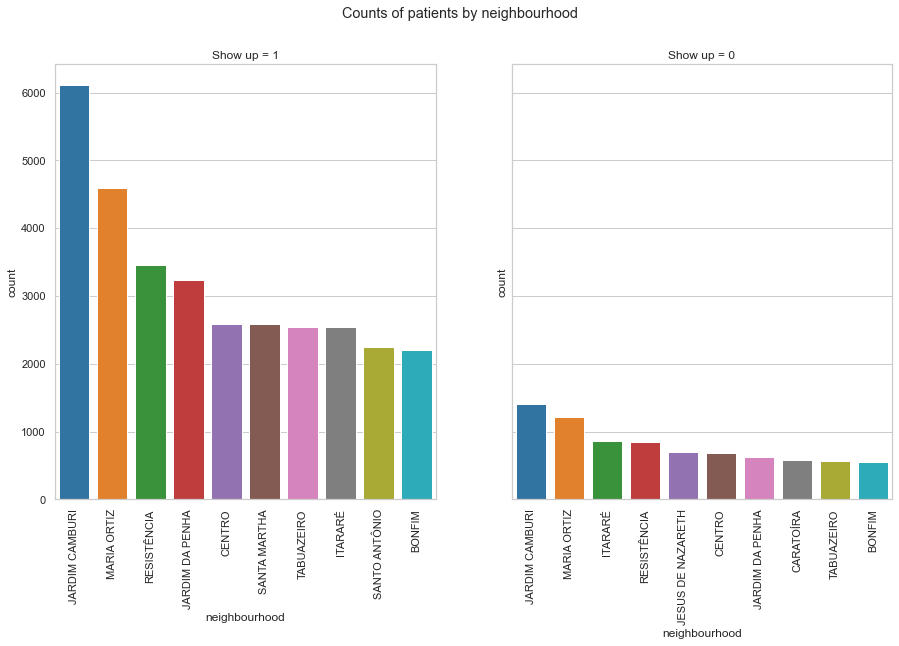

In [48]:
neib_high_show, neib_high_noshow = my_plot('count', False, df)

Now let's filter by them, and check again !

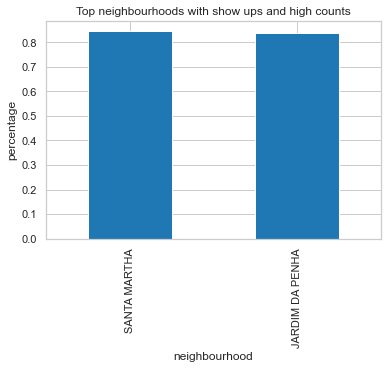

In [49]:
neib_show[neib_show['neighbourhood'].isin(neib_high_show['neighbourhood'])]\
.plot(kind='bar', x='neighbourhood', y='percentage', legend=False,
      ylabel = 'percentage', title='Top neighbourhoods with show ups and high counts');

So if you are in any of these two neighbourhoods, chances are the patient is going to show up! <br>
And...

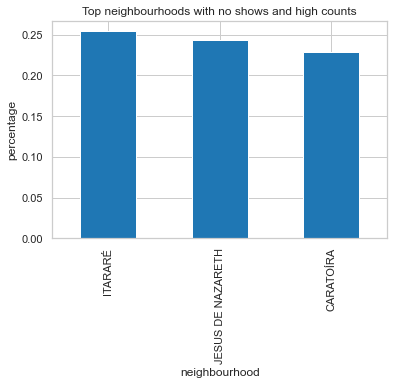

In [50]:
neib_noshow[neib_noshow['neighbourhood'].isin(neib_high_noshow['neighbourhood'])]\
.plot(kind='bar', x='neighbourhood', y='percentage', legend=False,
      ylabel = 'percentage', title='Top neighbourhoods with no shows and high counts');

If you are in any of these three, you have the highest chances that patients are NOT going to show up!

### Does sms messages help in showing up ?

well the answer to this question might be inaccurate due to the data, but i'll do my best

Text(0.515, 1.03, 'Percentage of patients that received SMS divided by Showing Up')

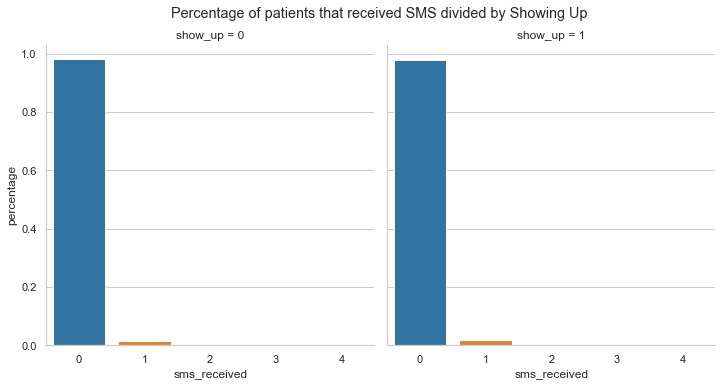

In [51]:
data = df.groupby('show_up')['sms_received'].value_counts(normalize=True).rename('percentage').reset_index()
g = sns.catplot(kind='bar', data=data, x='sms_received', y='percentage', col='show_up');
g.fig.suptitle('Percentage of patients that received SMS divided by Showing Up', y=1.03, x=0.515)

In [52]:
df.corr().loc['sms_received']['show_up']

0.006009242125859756

Text(0.5, 1.02, 'Distribution of Patients that received SMS divided by Showing Up')

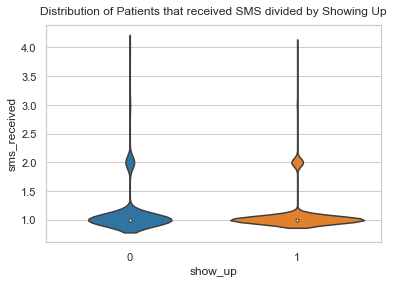

In [53]:
g = sns.violinplot(data=df.query('sms_received > 0'), y='sms_received', x='show_up', split=True);
g.set_title('Distribution of Patients that received SMS divided by Showing Up', y=1.02)

Well, based on these charts, sending an sms, might slightly help, but the chances of that happening are extremely low!

### Do Disease affect whether a patient will show up or not?

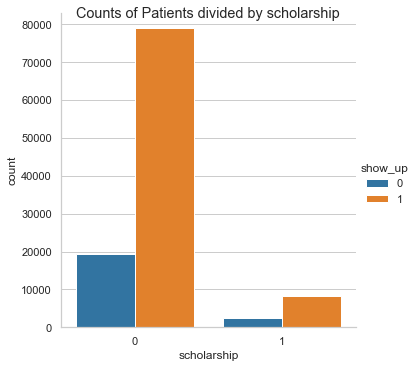

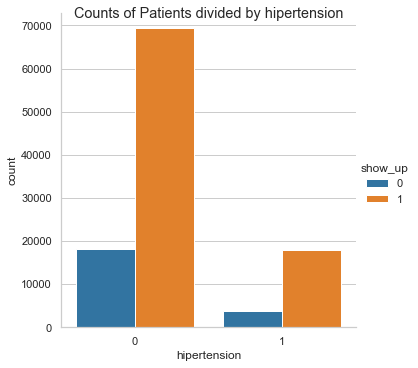

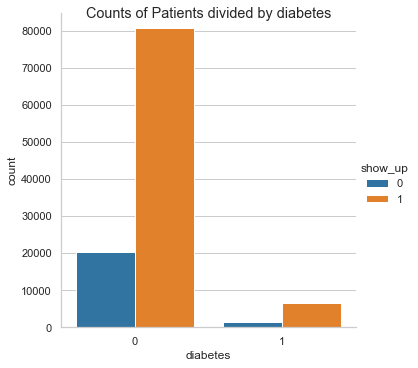

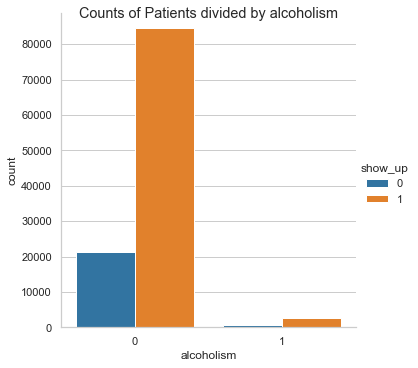

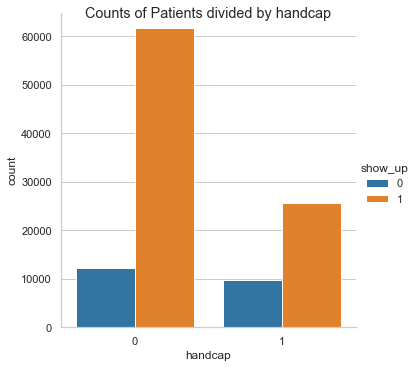

In [54]:
cols = ['scholarship', 'hipertension', 'diabetes', 'alcoholism', 'handcap']

for v in cols:
    g=sns.catplot(data=df, kind='count', x=v, hue='show_up')
    g.fig.suptitle('Counts of Patients divided by {}'.format(v))
    plt.show()

Well, the graphs showing the counts aren't really fair to compare with, since the numbers are not close at all, and some data are relatively negligible like alcoholism and diabetes, so it's not obviouse whether each condition had an effect or not, so let's look at this differently...

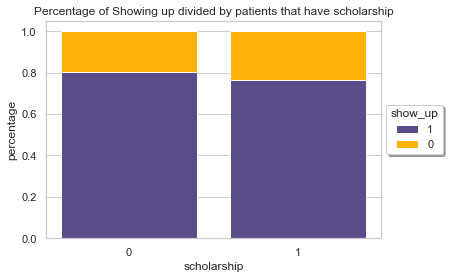

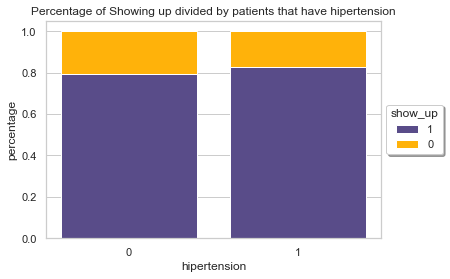

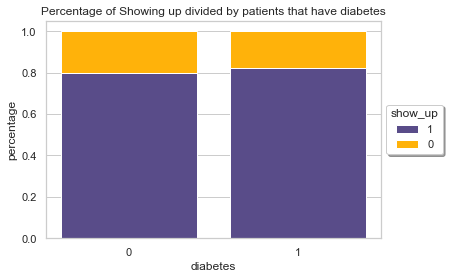

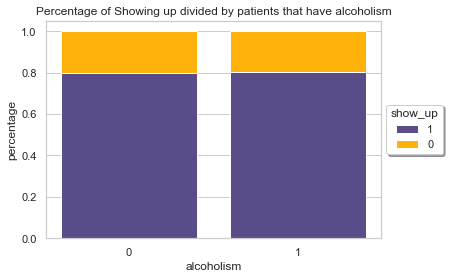

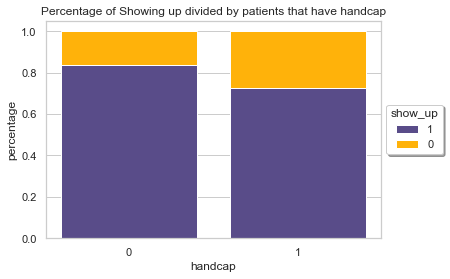

In [55]:
for i in cols:
    data = df.groupby(i)['show_up'].value_counts(normalize=True).rename('percentage').reset_index()

    fig, ax = plt.subplots()
    sns.barplot(data=data[data['show_up'] == 1], x=i, y='percentage', color='#534293', label='1', ci=None)
    ax.bar(x=data[data['show_up']==0][i],
           height=data[data['show_up']==0]['percentage'],
           bottom=data[data['show_up']==1]['percentage'], 
           color='#ffb20a',
           label='0')
    ax.set_title('Percentage of Showing up divided by patients that have {}'.format(i))
    ax.legend(title='show_up', shadow=True, loc='center left', bbox_to_anchor=(1, 0.5))

well the percentage of showing up is fairly the same whether any of the condition is there or not, <br>
except the handcap condition which happens to have ***less*** percentages of showing up !!

<a id='conclusions'></a>
## Conclusions

So in conclusion, we see that: <br>
- age or gender don't have a correlation with showing up to the appointment. <br>
- the day of the week however, seems to have some kind of activity at tuesdays and wednesdays. <br>
- we also learned that more waiting days means less probability of showing up. <br>
- the more appointments the patient makes, the more likely he/she will show up! <br>
- we learned more about neighbourhoods where the percentages of showing up is high, and others where it's low. <br>
- we found out that it's almost useless to send out sms messages, one message might actually help, bu more messages are just a waste.<br>
- and finally, having a special condition doesn't have anything to do with showing up, unless that condition is handcap, in which case, showing up will be ***less*** probable.


## Limitations

Please note that the analyses made are not 100% percent accurate, for several reasons: <br>
- There could be other relative data that was not recorded.
- There might be some inaccuracies while filling the data.
- Changes could have happened to the IDs' while transporting the data from 1 software to another.
- There are data that haven't been recoreded
- Sometime I find biasing in the data, which could be due to putting a default value instead of null, which is a bit misleading.


In [56]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'patients_appointments.ipynb'])

0